In [1]:
import findspark
findspark.init()

In [98]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import tempfile

In [8]:
spark = SparkSession.builder. \
    appName("pyspark-assesment"). \
    getOrCreate()

### Read data

In [82]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)

In [83]:
# ==========================================
# 1. DETAILED ANALYSIS OF SOURCE DATA
# ==========================================

print("--- Data Schema: Column Types (Numerical vs Character) ---")
df.printSchema()

--- Data Schema: Column Types (Numerical vs Character) ---
root
 |-- Job ID: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: string (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: string (nullable = true)
 |-- Salary Range To: string (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 

In [85]:
# =========================================================================
# 1. DATA PROCESSING & CLEANING
# =========================================================================
def clean_and_process(df):
    """
    Handles type casting, null imputation, and salary standardization.
    """
    # FIX: Explicitly cast to DoubleType to avoid IllegalArgumentException
    numeric_cols = ["Salary Range From", "Salary Range To"]
    for col in numeric_cols:
        df = df.withColumn(col, F.col(col).cast(DoubleType()))
    
    # Handle Missing Data: Fill numeric nulls with median
    median_val = df.stat.approxQuantile("Salary Range To", [0.5], 0.01)[0]
    df = df.fillna(median_val, subset=numeric_cols)
    
    # Standardize Salary to Annual (Assumes 2080 hrs/yr for Hourly)
    df = df.withColumn("Annual_Salary", 
        F.when(F.col("Salary Frequency") == "Hourly", F.col("Salary Range To") * 2080)
         .when(F.col("Salary Frequency") == "Daily", F.col("Salary Range To") * 260)
         .otherwise(F.col("Salary Range To")))
    
    # Feature Removal: Dropping low-value/high-null columns
    df = df.drop("Post Island", "Recruitment Contact", "Post Until")
    
    return df

In [86]:
# ==========================================
# 2. RESOLVING KPIs
# ==========================================
# Top 10 Job Posting per Category
print("--- KPI: Top 10 Job Postings per Category ---")
top_10_categories = df.groupBy("Job Category") \
    .count() \
    .orderBy(F.desc("count")) \
    .limit(10)
top_10_categories.show(truncate=False)

--- KPI: Top 10 Job Postings per Category ---
+-----------------------------------------+-----+
|Job Category                             |count|
+-----------------------------------------+-----+
|Engineering, Architecture, & Planning    |504  |
|Technology, Data & Innovation            |313  |
|Legal Affairs                            |226  |
|Public Safety, Inspections, & Enforcement|182  |
|Building Operations & Maintenance        |181  |
|Finance, Accounting, & Procurement       |169  |
|Administration & Human Resources         |134  |
|Constituent Services & Community Programs|129  |
|Health                                   |125  |
|Policy, Research & Analysis              |124  |
+-----------------------------------------+-----+



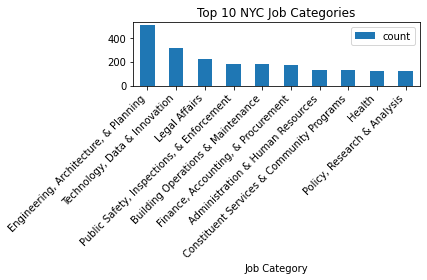

In [88]:
# Converting the Top 10 Categories to Pandas for a quick bar chart
pd_df = top_10_categories.toPandas()
pd_df.plot(kind='bar', x='Job Category', y='count', title='Top 10 NYC Job Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [89]:
# Salary Distribution per Job Category
print("--- KPI: Salary Distribution per Job Category ---")
salary_dist = df_standardized.groupBy("Job Category") \
    .agg(
        F.min("Annual_Salary").alias("Min_Salary"),
        F.max("Annual_Salary").alias("Max_Salary"),
        F.avg("Annual_Salary").alias("Avg_Salary"),
        F.stddev("Annual_Salary").alias("Salary_StdDev")
    )
salary_dist.show(truncate=False)

--- KPI: Salary Distribution per Job Category ---
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------------+------------------+------------------+
|Job Category                                                                                                                                                                                      |Min_Salary|Max_Salary       |Avg_Salary        |Salary_StdDev     |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------------+------------------+------------------+
|Administration & Human Resources Communications & Intergovernmental Affairs Engineering, Architecture, & Planning Policy, Research & Analysis                

In [90]:
# Correlation between Higher Degree and Salary
# Mapping degrees to numerical values for correlation analysis
print("--- KPI: Correlation between Degree and Salary ---")
df_corr = df_standardized.withColumn("Degree_Level", 
    F.when(F.col("Minimum Qual Requirements").contains("Master"), 3)
     .when(F.col("Minimum Qual Requirements").contains("Bachelor"), 2)
     .otherwise(1))
correlation_val = df_corr.stat.corr("Degree_Level", "Annual_Salary")
print(f"Correlation coefficient: {correlation_val}")

--- KPI: Correlation between Degree and Salary ---
Correlation coefficient: 0.026841443964606786


In [91]:
# Job Posting with Highest Salary per Agency
print("--- KPI: Highest Salary Job Posting per Agency ---")
window_spec = Window.partitionBy("Agency").orderBy(F.desc("Annual_Salary"))
highest_salary_per_agency = df_standardized.withColumn("rank", F.dense_rank().over(window_spec)) \
    .filter(F.col("rank") == 1) \
    .select("Agency", "Business Title", "Annual_Salary").distinct()
highest_salary_per_agency.show(truncate=False)

--- KPI: Highest Salary Job Posting per Agency ---
+------------------------------+------------------------------------------------------------+-------------+
|Agency                        |Business Title                                              |Annual_Salary|
+------------------------------+------------------------------------------------------------+-------------+
|LANDMARKS PRESERVATION COMM   |LANDMARKS PRESERVATIONIST, PRESERVATION DEPT                |64297.0      |
|OFFICE OF COLLECTIVE BARGAININ|COLLEGE AIDE - CLERICAL                                     |21548.8      |
|FIRE DEPARTMENT               |Senior Enterprise Applications Integration Developer        |144929.0     |
|ADMIN FOR CHILDREN'S SVCS     |Director of Technical  Support                              |156829.0     |
|MANHATTAN COMMUNITY BOARD #8  |Community Assistant                                         |39520.0      |
|TAX COMMISSION                |CITY ASSESSOR                                        

In [92]:
# Highest Paid Skills
# Exploding skills to find keywords associated with top salaries
print("--- KPI: Highest Paid Skills (Exploratory Analysis) ---")
top_skills = df_standardized.withColumn("Skill", F.explode(F.split(F.col("Preferred Skills"), ","))) \
    .groupBy("Skill") \
    .agg(F.avg("Annual_Salary").alias("Avg_Skill_Salary")) \
    .orderBy(F.desc("Avg_Skill_Salary")) \
    .limit(10)
top_skills.show(truncate=False)

--- KPI: Highest Paid Skills (Exploratory Analysis) ---
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|Skill                                                                                                                                                                                                                                                                                      |Avg_Skill_Salary  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
| and one year of medical pra

In [93]:
# =========================================================================
# 3. FEATURE ENGINEERING (3 Techniques)
# =========================================================================

def apply_features(df):
    # Technique 1: Ordinal Encoding for Education
    df = df.withColumn("Education_Rank", 
        F.when(F.col("Minimum Qual Requirements").contains("Master"), 3)
         .when(F.col("Minimum Qual Requirements").contains("Bachelor"), 2)
         .otherwise(1))
    
    # Technique 2: Salary Binning
    df = df.withColumn("Job_Seniority", 
        F.when(F.col("Annual_Salary") < 70000, "Junior")
         .when(F.col("Annual_Salary") < 110000, "Mid-Level")
         .otherwise("Senior"))
    
    # Technique 3: Skill Count (Tokenization)
    df = df.withColumn("Skill_Count", F.size(F.split(F.col("Preferred Skills"), " ")))
    
    return df

# Executing Pipeline
df_cleaned = clean_and_process(df)
df_final = apply_features(df_cleaned)

In [94]:
# 4. FEATURE VIABILITY ANALYSIS (Good vs. Bad Fields)
print("--- 2.1 Identifying Good Features via Cardinality ---")
# High cardinality fields (like Job ID) are identifiers, not features.
# Low cardinality fields (like Agency or Posting Type) are good for encoding.
for col in ["Agency", "Posting Type", "Full-Time/Part-Time indicator", "Salary Frequency"]:
    distinct_count = df_final.select(col).distinct().count()
    print(f"Feature: {col} | Distinct Values: {distinct_count}")

--- 2.1 Identifying Good Features via Cardinality ---
Feature: Agency | Distinct Values: 52
Feature: Posting Type | Distinct Values: 2
Feature: Full-Time/Part-Time indicator | Distinct Values: 3
Feature: Salary Frequency | Distinct Values: 3


In [95]:
print("--- 2.2 Feature Removal (Based on Profiling) ---")
# Removing 'Post Island' and 'Recruitment Contact' because they are largely empty 
# or contain redundant information.
cols_to_drop = ["Post Island", "Recruitment Contact", "Post Until", "Job ID"]
df_features = df_final.drop(*cols_to_drop)

--- 2.2 Feature Removal (Based on Profiling) ---


In [96]:
# =========================================================================
# 3. STATISTICAL CORRELATION FOR FEATURE SELECTION
# =========================================================================

print("--- 3.1 Numerical Correlation Matrix (Salary Range) ---")
# Checking if 'Salary Range From' and 'Salary Range To' are perfectly correlated
# (If so, we only need one as a target feature)
correlation = df_features.stat.corr("Salary Range From", "Salary Range To")
print(f"Correlation between Salary Min and Max: {correlation}")


--- 3.1 Numerical Correlation Matrix (Salary Range) ---
Correlation between Salary Min and Max: 0.748932127334258


In [107]:
# STEP 3: RENAME COLUMNS FOR PARQUET
# Standardizing all column names to remove spaces
for col in df_final.columns:
    df = df.withColumnRenamed(col, col.replace(" ", "_").replace("/", ""))

In [109]:
# 4. STORAGE
df.write.mode("overwrite").parquet("processed_nyc_jobs.parquet")